# Objective
Create a model using advanced techniques for a case study of a prediction model that can be used to evaluate loan repayment behaviour of currently excluded customers of formal financial services
https://www.kaggle.com/c/home-credit-default-risk

# Preparation

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import matplotlib.pyplot as plt
import os
import errno
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report, confusion_matrix, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [2]:
%load_ext pycodestyle_magic
%flake8_on
%matplotlib inline

### Create folder structure

In [3]:
os.chdir('..')
output_folder = './reports/figures/basic/'
cleaned_folder = './data/processed/basic/'
external_data = './data/external/basic/'

# Import data

In [4]:
x_train = pd.read_csv(cleaned_folder + 'x_train.csv')
x_test = pd.read_csv(cleaned_folder + 'x_test.csv')
y_train = pd.read_csv(cleaned_folder + 'y_train.csv', dtype='int64')
y_test = pd.read_csv(cleaned_folder + 'y_test.csv', dtype='int64')
test_df = pd.read_csv(cleaned_folder + 'test_df.csv')
test_ids_df = pd.read_csv(cleaned_folder + 'test_ids_df.csv')

In [5]:
y_test = y_test['TARGET']
y_train = y_train['TARGET']

# Balance dataset

In [6]:
# Verify that the dataset is balanced
y_train.value_counts(normalize=False)

0    183959
1     16243
Name: TARGET, dtype: int64

**Result**: dataset unbalanced with only 9% customers with payment difficulties, which can be expected.


In [7]:
# Merge outcome variable & features
train_df = pd.concat([x_train, y_train], axis=1)

In [8]:
# Separate dataset based on outcome variable
no_pay_prob = train_df[train_df['TARGET'] == 0]
pay_prob = train_df[train_df['TARGET'] == 1]

In [9]:
# Count of customers with payment difficulties
pay_prob.shape

(16243, 16)

In [10]:
# Separate dataset in preparation of modelling
y_train = train_df['TARGET']
x_train = train_df.drop('TARGET', axis=1)

# Feature selection

In [11]:
rf_feature_select = SelectFromModel(RandomForestClassifier(n_estimators=100))
rf_feature_select.fit(x_train, y_train)

rf_sel_feature_count = rf_feature_select.get_support()
rf_selected_features = x_train.loc[:, rf_sel_feature_count].columns.tolist()
print(str(len(rf_selected_features)), 'selected features')

4 selected features


In [12]:
print('Selected features:', rf_selected_features)

Selected features: ['DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED']


In [13]:
# Select strongest features
x_train = x_train[rf_selected_features]
x_test = x_test[rf_selected_features]
test_df = test_df[rf_selected_features]

# Modelling

In [31]:
# Use default logistic regression, without adjusting parameters
model1 = LogisticRegression()
model1.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Model evaluation

In [15]:
# Create predictions from the training data on the test data
y_pred_mod_1 = model1.predict(x_test)

In [16]:
# Evaluate model based on training data
pred_prob_1 = model1.predict_proba(x_test)

In [17]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_1[:, 1], pos_label=1)

In [18]:
# Create benchmark predictions based on random chance for ROC comparison
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [19]:
# Calculate auc scores
auc_score1 = roc_auc_score(y_test, pred_prob_1[:, 1])

print('Logistic regression AUC:', auc_score1)

Logistic regression AUC: 0.6023764908017762


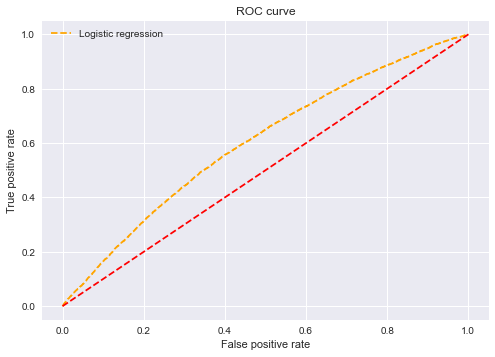

In [20]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='orange', label='Logistic regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend(loc='best')
plt.savefig(cleaned_folder + 'ROC_graph', dpi=300)
plt.show()

In [21]:
# Create confusion matrix
print("Confusion matrix model 1")
y_actual = pd.Series(y_test, name='Actual')
y_predicted = pd.Series(y_pred_mod_1, name='Predicted')
pd.crosstab(y_actual, y_predicted)

Confusion matrix model 1


Predicted,0
Actual,
0,78828
1,6973


In [23]:
print(classification_report(y_predicted, y_actual))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     85801
           1       0.00      0.00      0.00         0

    accuracy                           0.92     85801
   macro avg       0.50      0.46      0.48     85801
weighted avg       1.00      0.92      0.96     85801



# Create final model

In [24]:
# Combine train and test datasets
x_df = pd.concat([x_train, x_test])
y_df = pd.concat([y_train, y_test])

In [25]:
x_df.shape

(286003, 4)

In [26]:
y_df.shape

(286003,)

In [27]:
final_model = LogisticRegression()
final_model.fit(x_df, y_df)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Submission

In [28]:
# Create predictions based on generated model
prediction = final_model.predict(test_df)

In [29]:
# Generate Submission File
SK_ID_CURR = list(test_ids_df['SK_ID_CURR'])
predicted_test_values = pd.DataFrame({'SK_ID_CURR': SK_ID_CURR, 'TARGET': prediction})
predicted_test_values.to_csv(external_data + 'Submission_file.csv', index=False)

In [30]:
prediction.shape

(44832,)